In [1]:
from sites import cat_w_sites
import sqlite3
import ast
from collections import defaultdict
from urllib.parse import urlparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def getDomain(s):
    o = urlparse(s)
    domain = o.netloc
    if not domain:
        return s
    return domain

In [3]:
cats = [cat for cat, _ in cat_w_sites]
domain2catInd = dict()
for i, (_, sites) in enumerate(cat_w_sites):
    for site in sites:
        domain = getDomain(site)
        domain2catInd[domain] = i
print(len(domain2catInd))
print(domain2catInd)

100
{'www.peachprincess.com': 0, 'www.g-collections.com': 0, 'www.hirameki-int.com': 0, 'www.jastusa.com': 0, 'www.himeyashop.com': 0, 'ryogamasaki.netfirms.com': 0, 'www.hentai-games.com': 0, 'www.hentai-comics.com': 0, 'www.canadahentai.com': 0, 'members.tripod.com': 0, 'www.sfanimeclub.com': 1, 'www.stevens.edu': 1, 'www.indyanime.org': 1, 'www.freewebs.com': 1, 'www.auburn.edu': 1, 'www.ctrl-a.org': 1, 'www.fresnoanime.com': 1, 'www.delawareanimesociety.com': 1, 'www.jaamke.com': 1, 'www.otakuanime.org': 1, 'www.cma-canada.org': 2, 'www.aicpa.org': 2, 'www.accountants.org.sg': 2, 'www.nasba.org': 2, 'www.icap.org.pk': 2, 'www.isaca.org': 2, 'www.cica.ca': 2, 'www.icai.ie': 2, 'www.jicpa.or.jp': 2, 'www.icaa.org.au': 2, 'www.intelligenceunited.com': 3, 'editor.altervista.org': 3, 'www.personal.kent.edu': 3, 'sigact.acm.org': 3, 'www.oopweb.com': 3, 'www.leekillough.com': 3, 'www.algosort.com': 3, 'alumni.imsa.edu': 3, 'www.eli.sdsu.edu': 3, 'www.cs.ucr.edu': 3, 'www.enginuity.com': 

In [4]:
con = sqlite3.connect('./datadir/crawl-data.sqlite')
cur = con.cursor()
# start from top_level_url, direct to Host in headers
rows = cur.execute("SELECT t.top_level_url, t.headers FROM http_requests AS t").fetchall()
graph = defaultdict(set) # key: target site, value: start site
for r in rows:
    start_site = r[0]
    header = ast.literal_eval(r[1])
    target_site = header[0][1]

    start_domain = getDomain(start_site)
    target_domain = getDomain(target_site)
    
    graph[target_domain].add(start_domain)
con.close()

In [5]:
# print(max([len(v) for v in graph.values()]))
# print(any(k is None for k in graph.keys()))

In [6]:
total_cat = len(cat_w_sites)
occurrence = [[0 for _ in range(total_cat)] for _ in range(total_cat)]
# print(graph.items())
for target_domain, start_domains in graph.items():
    total_start_domains = len(start_domains)
    start_domains_list = list(start_domains)
    for i1 in range(total_start_domains):
        for i2 in range(i1, total_start_domains):
            start_domain1 = start_domains_list[i1]
            start_domain2 = start_domains_list[i2]

            try:
                start_domain_id1 = domain2catInd[start_domain1]
                start_domain_id2 = domain2catInd[start_domain2]

                occurrence[start_domain_id1][start_domain_id2] += 1
                occurrence[start_domain_id2][start_domain_id1] += 1
            except:
                pass

# print(occurrence)

In [7]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-45, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

In [8]:
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

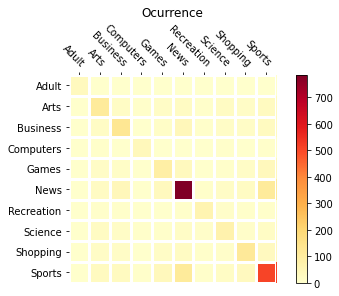

In [9]:
fig, ax = plt.subplots()
im, cbar = heatmap(np.array(occurrence), cats, cats, ax=ax,
                   cmap="YlOrRd")
# texts = annotate_heatmap(im, valfmt="{x:d}")
fig.tight_layout()
plt.title('Ocurrence')
plt.savefig('infoflow.png', bbox_inches="tight", dpi=300)
plt.show()